# Harry Markowitz's Efficient Frontier

### 📈 The Concept of Efficient Frontier

MPT shows that an investor can **combine different assets** to create a portfolio that:
- **Maximizes expected return** for a given level of risk, or
- **Minimizes risk** for a given expected return  

The theory introduces the concept of the **Efficient Frontier**:  
--> the set of **optimal portfolios** that deliver the **best possible trade-off** between **risk** and **return**.

<br>

### 🎲 How the simulation works
- Randomly assigns **weights** to each asset (while keeping total = 100%)  
- Calculates for every simulated portfolio:
  - **Expected return** $E(R_p)$
  - **Volatility** $σ_p$
  - **Sharpe Ratio** $S$  
- Repeats the process **50,000+ times** to create a **cloud of possible portfolios**  
- Identifies the portfolio with the **highest Sharpe Ratio** as the *optimal* allocation

<br>  

The script:
- Generates **50,000+ random portfolios**
- Calculates **Expected Return**, **Volatility**, and **Sharpe Ratio** for each
- Highlights the **Max Sharpe Portfolio** and plots the **Efficient Frontier**

<br>

---

<br> 

### 📊 Expected Return
Annualized expected return based on asset weights.

$E(R_p) = \sum_{i=1}^{n} w_i \cdot \bar{R_i} \times 252$

- **$E(R_p)$** : expected annual return  
- **$w_i$** : weight of asset *i* in the portfolio  
- **$\bar{R_i}$** : average daily log return of asset *i*  
- **252** : trading days in a year  

<br>

### 📉 Portfolio Volatility
Measures portfolio risk using the covariance matrix.

$σ_p = \sqrt{ w^T \cdot Σ \cdot w }$

- **$σ_p$** : annualized portfolio volatility  
- **$w$** : weight vector  
- **$Σ$** : annualized covariance matrix of returns  

<br>

### 📊 Sharpe Ratio
Assesses portfolio efficiency (return per unit of risk).

$S = \frac{E(R_p) - R_f}{σ_p}$

- **$S$** : Sharpe ratio  
- **$R_f$** : risk-free rate (e.g., 2%)  

<br>

### 📊 Portfolio Beta
Measures sensitivity of the portfolio to market movements.

$β_p = \frac{Cov(R_p, R_m)}{Var(R_m)}$

- **$β_p$** : portfolio beta relative to the market (S&P 500 proxy)  
- **$R_p$** : portfolio returns  
- **$R_m$** : market returns  

<br>  

---

<br> 

### 📊 Results
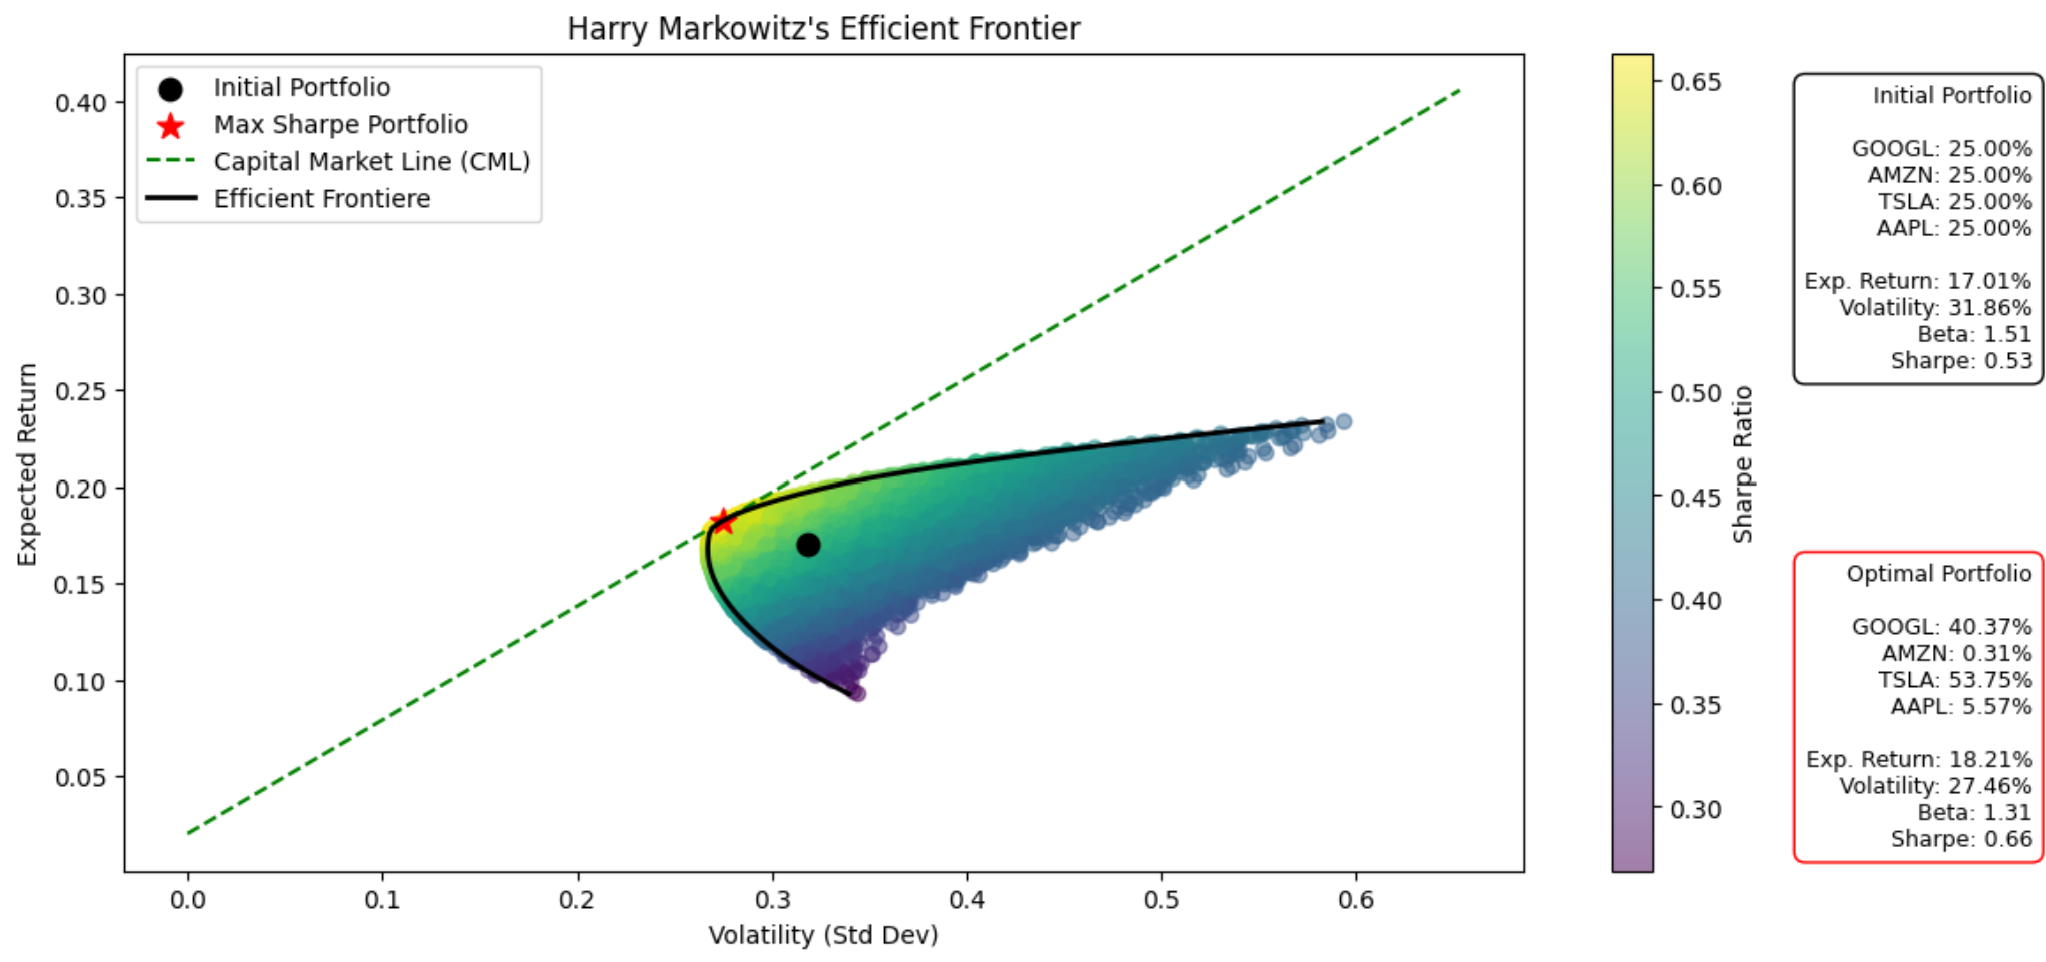



### 📊 What the chart shows
- Initial portfolio metrics (Return, Volatility, Sharpe, Beta)  
- Optimal portfolio metrics  
- Recommended **new weights per asset**  
<br>
- **Cloud of random portfolios** (colored by Sharpe Ratio)  
- **Optimal Portfolio** (Max Sharpe) highlighted in red  
- **Efficient Frontier** drawn in black (best risk-return combinations)  
- **Capital Market Line (CML)** showing the risk/return trade-off with a risk-free asset  

<br>

### The python script

C:\Users\Xtrai\AppData\Local\Temp\ipykernel_30924\1430595416.py:28: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  4 of 4 completed
C:\Users\Xtrai\AppData\Local\Temp\ipykernel_30924\1430595416.py:82: FutureWarning: YF.download() has changed argument auto_adjust default to True
  market = yf.download('^GSPC', start=start_date, end=end_date)['Close'].dropna()
[*********************100%***********************]  1 of 1 completed


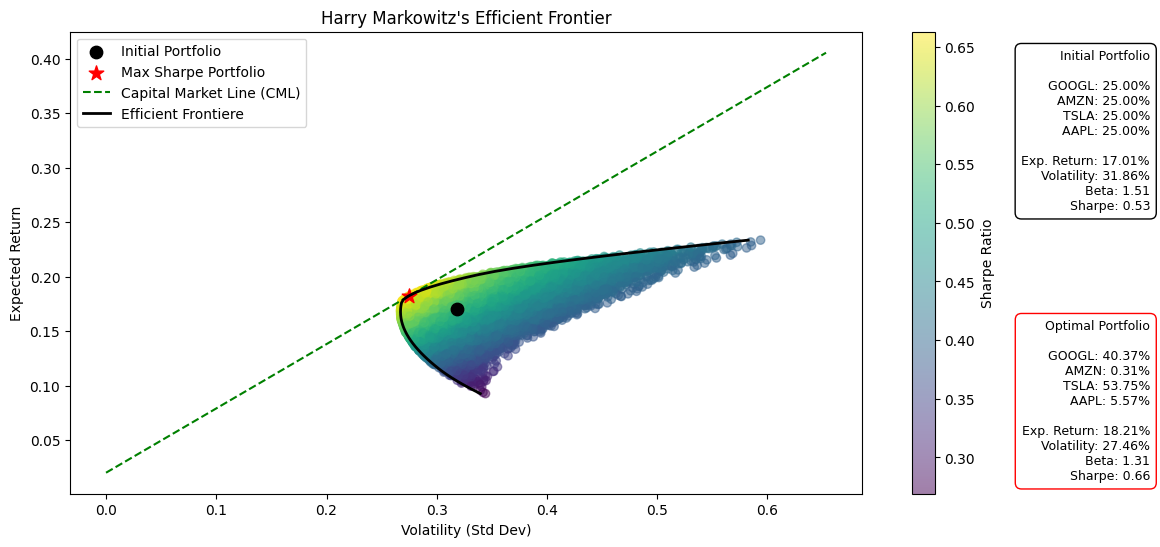

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.optimize import minimize




# 1. INPUTS PART
tickers = input("Enter tickers separated by commas (ex: GOOGL,AMZN,TSLA,AAPL): ")
tickers = [t.strip().upper() for t in tickers.split(',')]
n = len(tickers)

pond = input(f"Enter the initial weights (sum = 1), separated by commas (ex: 0.25,0.25,0.25,0.25): ")
initial_weights = np.array([float(x) for x in pond.split(',')])
if not np.isclose(np.sum(initial_weights), 1):
    raise ValueError("The sum of the weights must be 1.")

annees = int(input("Number of years of history to analyze (ex: 5): "))
end_date = datetime.today()
start_date = end_date - timedelta(annees * 365)



# 2. DATA DOWNLOAD PART
data = yf.download(tickers, start=start_date, end=end_date)['Close']
data = data.dropna()
data.columns = tickers



# 3. CALCULUS PART
log_returns = np.log(data / data.shift(1)).dropna()
trading_days = 252
average_log_returns = log_returns.mean() * trading_days
sigma = log_returns.cov() * trading_days



# 4. PORTFOLIO SIMULATIONS PART
nb_portfolio = 50000
weights = []
exp_returns = []
exp_vol = []
sharpe_ratio = []

for _ in range(nb_portfolio):
    w = np.random.random(n)
    w = w / np.sum(w)
    weights.append(w)
    exp_r = np.sum(average_log_returns * w)
    exp_v = np.sqrt(np.dot(w.T, np.dot(sigma, w)))
    exp_returns.append(exp_r)
    exp_vol.append(exp_v)
    sharpe_ratio.append(exp_r / exp_v)

exp_returns = np.array(exp_returns)
exp_vol = np.array(exp_vol)
sharpe_ratio = np.array(sharpe_ratio)
weights = np.array(weights)

max_index = sharpe_ratio.argmax()
optimal_weights = weights[max_index]




# 5. METRICS CALCULUS PART
def portfolio_beta(weights, log_returns, market_returns):
    port_ret = log_returns @ weights
    # Aligne les index pour éviter les erreurs de dimensions
    aligned = pd.concat([port_ret, market_returns], axis=1, join='inner').dropna()
    if aligned.shape[0] == 0:
        return np.nan
    cov = np.cov(aligned.iloc[:,0], aligned.iloc[:,1])[0,1]
    var = np.var(aligned.iloc[:,1])
    return cov / var

# Utilise le S&P500 comme marché de référence pour le calcul du beta
market = yf.download('^GSPC', start=start_date, end=end_date)['Close'].dropna()
market_log_returns = np.log(market / market.shift(1)).dropna().loc[log_returns.index]

# Initial portfolio
init_return = np.sum(average_log_returns * initial_weights)
init_vol = np.sqrt(np.dot(initial_weights.T, np.dot(sigma, initial_weights)))
init_sharpe = init_return / init_vol
init_beta = portfolio_beta(initial_weights, log_returns, market_log_returns)

# Optimal portfolio
opt_return = np.sum(average_log_returns * optimal_weights)
opt_vol = np.sqrt(np.dot(optimal_weights.T, np.dot(sigma, optimal_weights)))
opt_sharpe = opt_return / opt_vol
opt_beta = portfolio_beta(optimal_weights, log_returns, market_log_returns)




# 6. PLOTTING PART
plt.figure(figsize=(12,6))  # Agrandis la figure
plt.scatter(exp_vol, exp_returns, c=sharpe_ratio, cmap='viridis', alpha=0.5)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(init_vol, init_return, c='black', marker='o', s=80, label='Initial Portfolio')
plt.scatter(opt_vol, opt_return, c='red', marker='*', s=120, label='Max Sharpe Portfolio')
plt.xlabel('Volatility (Std Dev)')
plt.ylabel('Expected Return')
plt.title("Harry Markowitz's Efficient Frontier")
plt.legend()
plt.subplots_adjust(left=0.075)  # Nouvelle ligne ajoutée

# Prépare le texte à afficher
init_text = "Initial Portfolio\n\n" + "\n".join(
    [f"{t}: {w*100:.2f}%" for t, w in zip(tickers, initial_weights)]
) + "\n\n" + \
f"Exp. Return: {init_return:.2%}\nVolatility: {init_vol:.2%}\nBeta: {init_beta:.2f}\nSharpe: {init_sharpe:.2f}"

# Titre en rouge, reste du texte en noir
opt_title = r"$\bf{Optimal\ Portfolio}$"
opt_alloc = "\n" + "\n".join([f"{t}: {w*100:.2f}%" for t, w in zip(tickers, optimal_weights)]) + "\n\n"
opt_metrics = f"Exp. Return: {opt_return:.2%}\nVolatility: {opt_vol:.2%}\nBeta: {opt_beta:.2f}\nSharpe: {opt_sharpe:.2f}"
opt_text = "Optimal Portfolio\n\n" + "\n".join(
    [f"{t}: {w*100:.2f}%" for t, w in zip(tickers, optimal_weights)]
) + "\n\n" + \
f"Exp. Return: {opt_return:.2%}\nVolatility: {opt_vol:.2%}\nBeta: {opt_beta:.2f}\nSharpe: {opt_sharpe:.2f}"

# Affiche les textes dans une boîte à droite de la colorbar
plt.gcf().text(
    0.975, 0.85, init_text, fontsize=9, va='top', ha='right',
    bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="black", lw=1)
)
plt.gcf().text(
    0.975, 0.4, opt_text, fontsize=9, va='top', ha='right',
    bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="red", lw=1)
)

# Ajout de la Capital Market Line (CML)
risk_free_rate = 0.02  # 2%
cml_x = np.linspace(0, max(exp_vol)*1.1, 100)
cml_slope = (opt_return - risk_free_rate) / opt_vol
cml_y = risk_free_rate + cml_slope * cml_x
plt.plot(cml_x, cml_y, color='green', linestyle='--', label='Capital Market Line (CML)')

# Nouvelle frontière efficiente pour la tracer sur le graphique en noir
def minimize_volatility(target_return, average_log_returns, sigma):
    n = len(average_log_returns)
    constraints = (
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'eq', 'fun': lambda w: np.sum(average_log_returns * w) - target_return}
    )
    bounds = tuple((0, 1) for _ in range(n))
    initial_guess = np.repeat(1/n, n)
    result = minimize(
        lambda w: np.sqrt(np.dot(w.T, np.dot(sigma, w))),
        initial_guess,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    return result

returns_range = np.linspace(exp_returns.min(), exp_returns.max(), 50)
efficient_vol = []
efficient_ret = []

for r in returns_range:
    res = minimize_volatility(r, average_log_returns, sigma)
    if res.success:
        efficient_vol.append(res.fun)
        efficient_ret.append(r)


plt.plot(efficient_vol, efficient_ret, color='black', linewidth=2, label='Efficient Frontiere')

plt.legend()
plt.show()